In [1]:
import numpy as np

import pymc as pm
import aesara

import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
mu0, sigma0 = 10., 1.5
y0 = np.random.normal(mu0, sigma0, size=1000)

with pm.Model() as m:
    mu = pm.Normal('mu', 0, 100)
    sigma = pm.HalfNormal('sigma', 10)
    y = pm.Normal('y', mu, sigma, observed=y0)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/opt/miniconda3/envs/aesara-dev/lib/python3.9/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


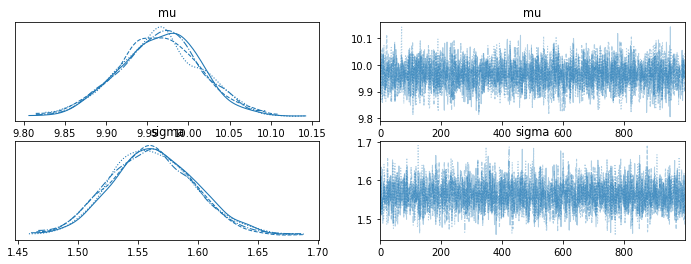

In [3]:
az.plot_trace(trace);

In [4]:
beta0 = 2.
sigma_new = 4.
X = np.linspace(-10, 10, 100)
y1 = np.random.normal(X * beta0, sigma_new)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


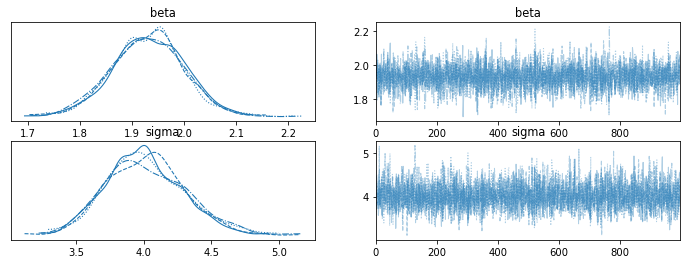

In [5]:
with pm.Model() as m2:
    beta = pm.Normal('beta', 0, 100)
    sigma = pm.HalfNormal('sigma', 10)
    y = pm.Normal('y', X * beta, sigma, observed=y1)
    trace2 = pm.sample(1000)

az.plot_trace(trace2);

In [6]:
from pymc.step_methods.arraystep import ArrayStepShared
from pymc.blocking import RaveledVars


class NormalProposal:
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

    def __call__(self, rng=None, size=()):
        if rng is None:
            rng = np.random
        return rng.normal(self.loc, scale=self.scale, size=size)


class FixedDistSample(ArrayStepShared):
    """Return sample from a fixed proposal distribution.
    """

    name = "fixed_dist_sample"

    generates_stats = False

    def __init__(self, vars, proposal_kwarg_dict, model=None):
        model = pm.modelcontext(model)
        initial_values = model.initial_point()

        vars = [model.rvs_to_values.get(var, var) for var in vars]
        vars = pm.inputvars(vars)
        initial_values_shape = [initial_values[v.name].shape for v in vars]
        self.ndim = int(sum(np.prod(ivs) for ivs in initial_values_shape))
        self.proposal_dist = NormalProposal(**proposal_kwarg_dict)

        shared = pm.make_shared_replacements(initial_values, vars, model)
        super().__init__(vars, shared)

    def astep(self, q0: RaveledVars) -> RaveledVars:
        point_map_info = q0.point_map_info
        q0 = q0.data
        q = self.proposal_dist(size=self.ndim)

        return RaveledVars(q, point_map_info)

In [7]:
from scipy.stats import t, norm
# Fit a t distribution to the data
# df, loc, scale = t.fit(np.ravel(trace.posterior['sigma'].values))
# the returning df is very large, so the distribution is approximately normal:
# loc, scale = norm.fit(np.ravel(trace.posterior['sigma'].values))

In [8]:
sigma_log__ = m.rvs_to_values[m.free_RVs[1]].tag.transform.forward(np.ravel(trace.posterior['sigma'].values))
sigma_log__ = aesara.function([], sigma_log__)()
# df, loc, scale = t.fit(sigma_log__)
loc, scale = norm.fit(sigma_log__)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>FixedDistSample: [sigma]
>NUTS: [beta]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


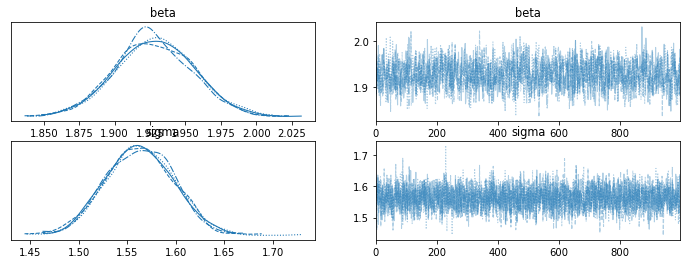

In [9]:
with m2:
    fixed_step = FixedDistSample([sigma], {'loc': loc, 'scale': scale})
    trace3 = pm.sample(1000, step=fixed_step)

az.plot_trace(trace3);